In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection
c:/Users/Admin/Data/ads_fraud_detection


In [2]:
# tf.keras.losses.Dice(
#     reduction='sum_over_batch_size', name='dice'
# )

# tf.keras.losses.binary_focal_crossentropy(
#     y_true,
#     y_pred,
#     apply_class_balancing=False,
#     alpha=0.25,
#     gamma=2.0,
#     from_logits=False,
#     label_smoothing=0.0,
#     axis=-1
# )

# tf.keras.losses.categorical_focal_crossentropy(
#     y_true,
#     y_pred,
#     alpha=0.25,
#     gamma=2.0,
#     from_logits=False,
#     label_smoothing=0.0,
#     axis=-1
# )

# keras_cv.losses.FocalLoss(
#     alpha=0.25, gamma=2, from_logits=False, label_smoothing=0, **kwargs
# )

In [3]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
    

In [4]:
save_dir=f"{exps_dir}/exp2/exp_smote"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [5]:
# feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
# feature_selection = {key: value for key, value in feature_selection.item().items()}
# feature_selection

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [6]:
# bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
# rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
# svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [7]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [8]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


In [9]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse_output=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(5089, 2) (19430, 2)


In [10]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(5089, 2)


In [11]:
x_test.shape

(5089, 34)

In [12]:
x_train.shape

(19430, 34)

In [13]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [14]:
print(x_train.shape[1])

34


#### * Xây dựng model:

#### * Xây dựng Stacked_model:

In [15]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [16]:
from tensorflow.keras import regularizers
from tabnet_keras.models import TabNetClassifier

# Định nghĩa tham số regularization
l2_reg = 0.01

learning_rate=0.1
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}



### Classification
model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)
# model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', 
#     kernel_regularizer=l2(0.01), **tabnet_params)
# model.compile(loss = 'categorical_crossentropy', optimizer = )
# model.fit(x_train, y_train, epochs = 100, batch_size = 1024)
# model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_9cat_loss, metrics=['accuracy',,f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=70,
    verbose=1,
    restore_best_weights=True,
)

# checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5",monitor='val_accuracy', verbose = 1, save_best_only=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=30,
    min_lr=0.000001,
    verbose=1,
)


In [17]:
y_train_onehot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [18]:
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [19]:
model.fit(x=x_train, y=y_train_onehot,
          validation_data=(x_test, y_test_onehot),
          batch_size=32,
          epochs=1200,
          callbacks=[early_stopping, lr_scheduler], class_weight={0: 0.5317035512094699, 1: 4.385551948051948})

Epoch 1/1200
608/608 [==============================] - 260s 427ms/step - loss: 0.7570 - accuracy: 0.7040 - f1_score: 0.6936 - val_loss: 0.4459 - val_accuracy: 0.8300 - val_f1_score: 0.5541 - lr: 0.1000
Epoch 2/1200
608/608 [==============================] - 258s 425ms/step - loss: 0.9477 - accuracy: 0.6292 - f1_score: 0.6146 - val_loss: 0.5329 - val_accuracy: 0.7019 - val_f1_score: 0.4627 - lr: 0.1000
Epoch 3/1200
608/608 [==============================] - 256s 421ms/step - loss: 0.9602 - accuracy: 0.6184 - f1_score: 0.6094 - val_loss: 0.6015 - val_accuracy: 0.5270 - val_f1_score: 0.3961 - lr: 0.1000
Epoch 4/1200
608/608 [==============================] - 257s 422ms/step - loss: 0.9049 - accuracy: 0.6402 - f1_score: 0.6317 - val_loss: 0.5914 - val_accuracy: 0.5416 - val_f1_score: 0.4063 - lr: 0.1000
Epoch 5/1200
608/608 [==============================] - 257s 423ms/step - loss: 0.8897 - accuracy: 0.6462 - f1_score: 0.6375 - val_loss: 0.5971 - val_accuracy: 0.5368 - val_f1_score: 0.400

In [20]:
model.summary()

Model: "tab_net_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder (TabNetEnc  multiple                  26880     
 oder)                                                           
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 26912 (105.12 KB)
Trainable params: 24592 (96.06 KB)
Non-trainable params: 2320 (9.06 KB)
_________________________________________________________________


#### * Kết quả đánh giá mô hình:

In [21]:
model.summary()

Model: "tab_net_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder (TabNetEnc  multiple                  26880     
 oder)                                                           
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 26912 (105.12 KB)
Trainable params: 24592 (96.06 KB)
Non-trainable params: 2320 (9.06 KB)
_________________________________________________________________


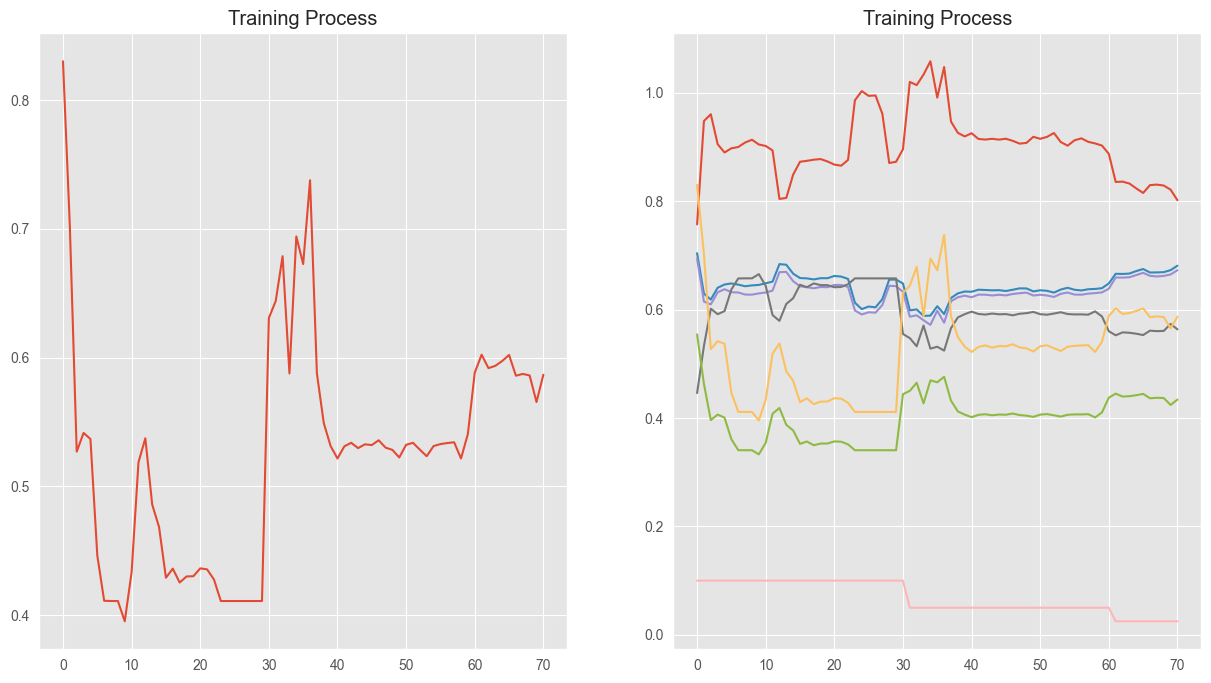

<Figure size 640x480 with 0 Axes>

In [22]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [23]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


160/160 [==============================] - 4s 26ms/step


0.8300255452937709

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.8300255452937709
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.90      4782
           1       0.16      0.42      0.23       307

    accuracy                           0.83      5089
   macro avg       0.56      0.64      0.57      5089
weighted avg       0.91      0.83      0.86      5089

Confusion Matrix:
[[4096  686]
 [ 179  128]]


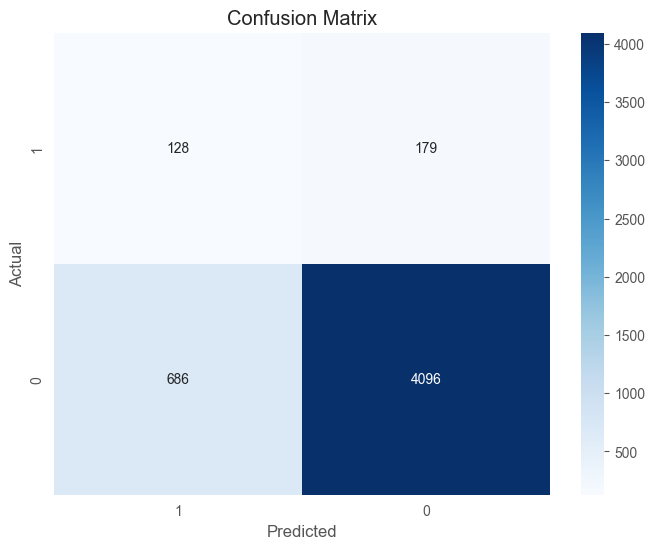

In [25]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

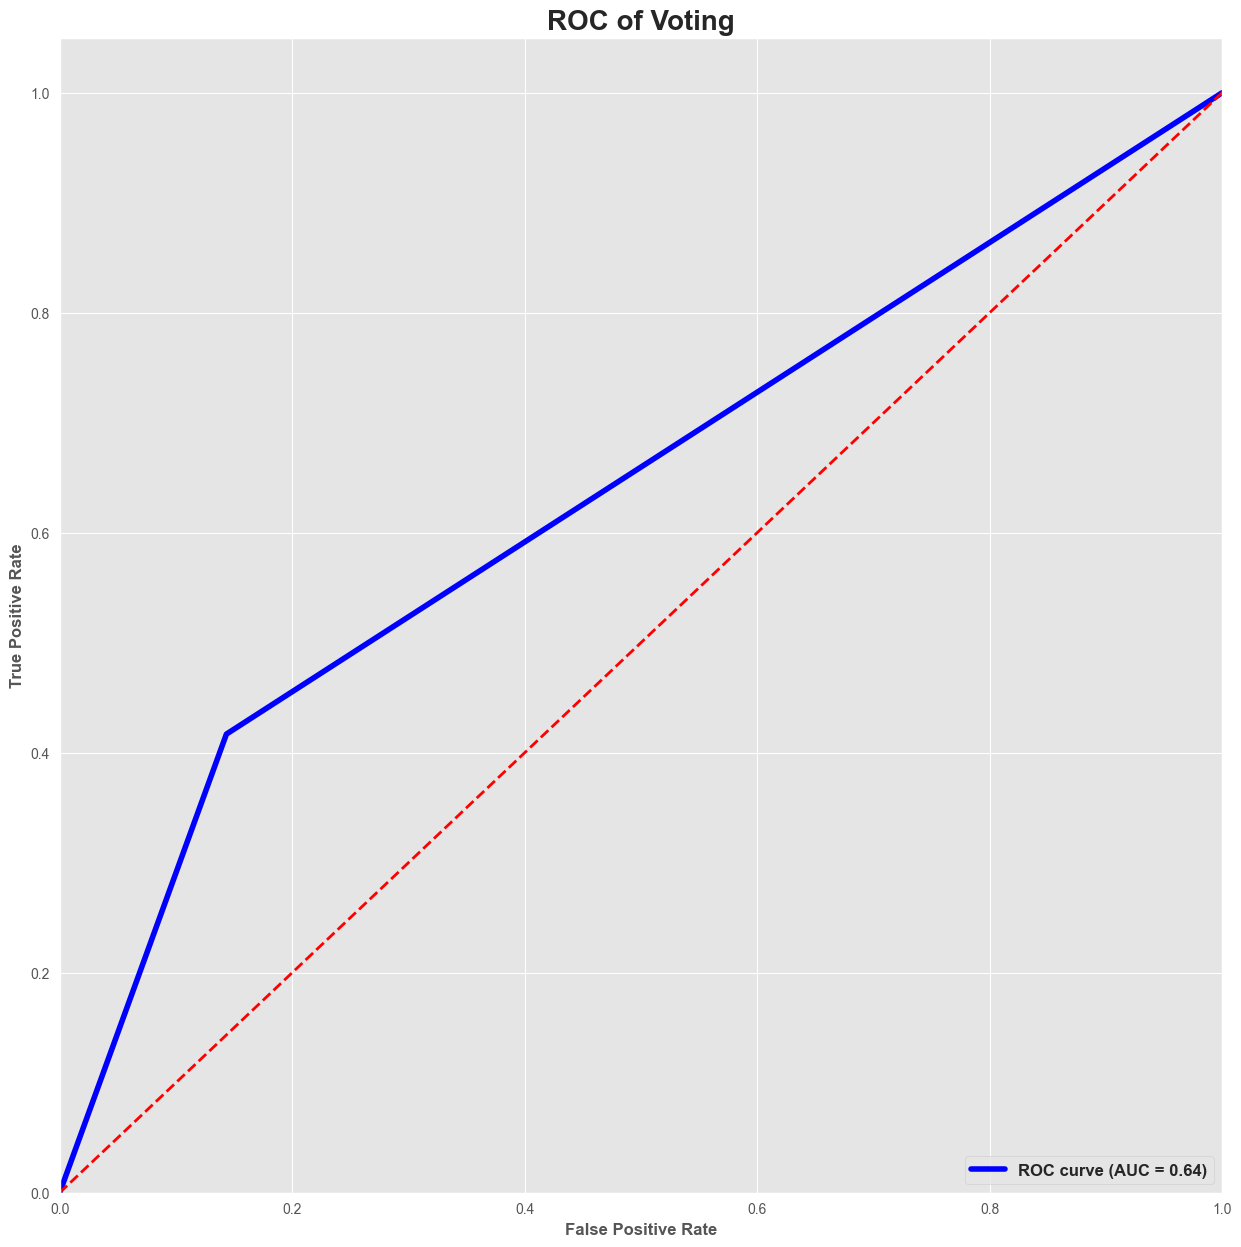

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [27]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [28]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    

In [29]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


NameError: name 'solandung' is not defined